In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.cosmology import WMAP9

In [2]:
def mass_function_parameters(logphi1, logphi2, logM_star, alpha1, alpha2):

    redshift_dependent_parameters = np.hstack((logphi1, logphi2, logM_star))

    return np.hstack((redshift_dependent_parameters, alpha1, alpha2))

In [3]:
def mass_function_parameter_priors(nsamples):

    logphi1 = np.random.uniform(-6, -2, nsamples)
    logphi2 = np.random.uniform(-6, -2, nsamples)
    logM_star = np.random.uniform(10, 12, nsamples)
    alpha1 = np.random.uniform(-0.5, 1, nsamples)
    alpha2 = np.random.uniform(-2, -0.5, nsamples)

    return np.transpose(np.vstack((logphi1, logphi2, logM_star, alpha1, alpha2)))

In [4]:
def mass_function_redshift_parameterisation_priors(nsamples):

    logphi1 = np.random.uniform([-100, -100, -100], [100, 100, 100], (nsamples, 3)) 
    logphi2 = np.random.uniform([-100, -100, -100], [100, 100, 100], (nsamples, 3))
    logM_star = np.random.uniform([-100, -100, -100], [100, 100, 100], (nsamples, 3))

    return np.hstack((logphi1, logphi2, logM_star))

In [5]:
def calculate_mass_function_parameters(z_grid, prior_draws):

    nsamples = prior_draws.shape[0]

    logphi1_params = np.reshape(prior_draws[:,:3], (nsamples, 3))
    logphi2_params = np.reshape(prior_draws[:,3:6], (nsamples, 3))
    logM_star_params = np.reshape(prior_draws[:,6:], (nsamples, 3))


    z0 = np.tile(np.ones_like(z_grid), (nsamples, 1))
    z1 = np.tile(z_grid, (nsamples, 1))
    z2 = np.tile(z_grid*z_grid, (nsamples, 1))

    phi1_c1 = np.reshape(logphi1_params[:, 0], (nsamples, 1))
    phi1_c2 = np.reshape(logphi1_params[:, 1], (nsamples, 1))
    phi1_c3 = np.reshape(logphi1_params[:, 2], (nsamples, 1))

    phi2_c1 = np.reshape(logphi2_params[:, 0], (nsamples, 1))
    phi2_c2 = np.reshape(logphi2_params[:, 1], (nsamples, 1))
    phi2_c3 = np.reshape(logphi2_params[:, 2], (nsamples, 1))

    logM_star_c1 = np.reshape(logM_star_params[:, 0], (nsamples, 1))
    logM_star_c2 = np.reshape(logM_star_params[:, 1], (nsamples, 1))
    logM_star_c3 = np.reshape(logM_star_params[:, 2], (nsamples, 1))


    logphi1 = phi1_c1*z0 + phi1_c2*z1 + phi1_c3*z2
    logphi2 = phi2_c1*z0 + phi2_c2*z1 + phi2_c3*z2
    logM_star = logM_star_c1*z0 + logM_star_c2*z1 + logM_star_c3*z2

    return [logphi1, logphi2, logM_star, logphi1_params, logphi2_params, logM_star_params]

In [6]:
def select_mass_function_params(redshift_parameterisation_params, z_grid):

    logphi1 = redshift_parameterisation_params[0]
    logphi2 = redshift_parameterisation_params[1]
    logM_star = redshift_parameterisation_params[2]

    df_logphi1 = pd.DataFrame(logphi1, columns=z_grid)
    df_logphi2 = pd.DataFrame(logphi2, columns=z_grid)
    df_logM_star = pd.DataFrame(logM_star, columns=z_grid)

    logphi1_params = redshift_parameterisation_params[3]
    logphi2_params = redshift_parameterisation_params[4]
    logM_star_params = redshift_parameterisation_params[5]

    selection_logphi1 = ((logphi1 < -2)*(logphi1 > -6))
    selection_logphi2 = ((logphi2 < -2)*(logphi2 > -6))
    selection_logM_star = ((logM_star < 12)*(logM_star > 10))

    selected_logphi1 = selection_logphi1*logphi1
    selected_logphi2 = selection_logphi2*logphi2
    selected_logM_star = selection_logM_star*logM_star

    selected_logphi1_params = selection_logphi1*logphi1_params
    selected_logphi2_params = selection_logphi2*logphi2_params
    selected_logM_star_params = selection_logM_star*logM_star_params

    return [selected_logphi1, selected_logphi2, selected_logM_star, selected_logphi1_params, selected_logphi2_params, selected_logM_star_params]

    

In [29]:
z_grid = np.linspace(0, 7, 8)
data = calculate_mass_function_parameters(z_grid, mass_function_redshift_parameterisation_priors(10000))
df_logphi1 = pd.DataFrame(data[0], columns=z_grid)
df_logphi1_params = pd.DataFrame(data[3], columns=['c1', 'c2', 'c3'])
new = df_logphi1.join(df_logphi1_params)
#new = new.drop(new.iloc[:, 0:len(z_grid)] > -2)
#new = new.drop(new.iloc[:, 0:len(z_grid)] < -6)
new


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,c1,c2,c3
0,3.127845,-134.680047,-411.045390,-825.968183,-1379.448427,-2071.486121,-2902.081267,-3871.233863,3.127845,-68.529167,-69.278725
1,39.751770,-91.403250,-321.698073,-651.132700,-1079.707129,-1607.421363,-2234.275399,-2960.269239,39.751770,-81.585118,-49.569902
2,11.839980,-72.528119,-196.873760,-361.196941,-565.497663,-809.775926,-1094.031729,-1418.265073,11.839980,-64.379329,-19.988770
3,88.073984,247.178286,551.198679,1000.135163,1593.987737,2332.756401,3216.441156,4245.042002,88.073984,86.646257,72.458045
4,-96.945035,-153.909934,-235.828066,-342.699429,-474.524025,-631.301852,-813.032912,-1019.717205,-96.945035,-44.488283,-12.476616
...,...,...,...,...,...,...,...,...,...,...,...
9995,-2.102871,136.378065,452.332270,945.759745,1616.660488,2465.034501,3490.881783,4694.202334,-2.102871,49.744302,88.736635
9996,-5.075324,125.889606,358.287502,692.118364,1127.382193,1664.078988,2302.208749,3041.771477,-5.075324,80.248446,50.716483
9997,1.561543,-112.341778,-355.325749,-727.390371,-1228.535644,-1858.761567,-2618.068141,-3506.455365,1.561543,-49.362995,-64.540325
9998,-59.816532,-53.269315,117.364398,452.084607,950.891311,1613.784510,2440.764204,3431.830395,-59.816532,-75.496030,82.043248


In [7]:
def sample_mass_function_parameter_priors(nsamples, seed=0):

    logphi1 = np.random.uniform(-6, -2, nsamples)
    logphi2 = np.random.uniform(-6, -2, nsamples)
    logMstar = np.random.uniform(10, 12, nsamples)
    alpha1 = np.random.uniform(-0.5, 1, nsamples)
    alpha2 = np.random.uniform(-2, -0.5, nsamples)

    return np.transpose(np.vstack((logphi1, logphi2, logMstar, alpha1, alpha2)))

In [8]:
def schechter(logm, logphi, logm_star, alpha):

    ones = np.ones_like(alpha)
    logm = np.ones_like(logm_star)*logm

    return np.log(10)*(10**logphi)*10**((logm-logm_star)*(alpha+ones))*np.exp(-10**(logm-logm_star))

def mass_function(z, logm, mass_function_params):

    logphi1, logphi2, logm_star, alpha1, alpha2 = np.hsplit(mass_function_params, 5)

    return schechter(logm, logphi1, logm_star, alpha1) + schechter(logm, logphi2, logm_star, alpha2)

(array([   208.,   1877.,   7614.,  21551.,  38846.,  57249.,  75097.,
         90564., 102497., 110411., 114659., 114513., 102914.,  71068.,
         42105.,  25182.,  13995.,   6764.,   2498.,    388.]),
 array([-6.58671332, -6.24111094, -5.89550855, -5.54990616, -5.20430377,
        -4.85870138, -4.51309899, -4.16749661, -3.82189422, -3.47629183,
        -3.13068944, -2.78508705, -2.43948466, -2.09388228, -1.74827989,
        -1.4026775 , -1.05707511, -0.71147272, -0.36587033, -0.02026795,
         0.32533444]),
 <BarContainer object of 20 artists>)

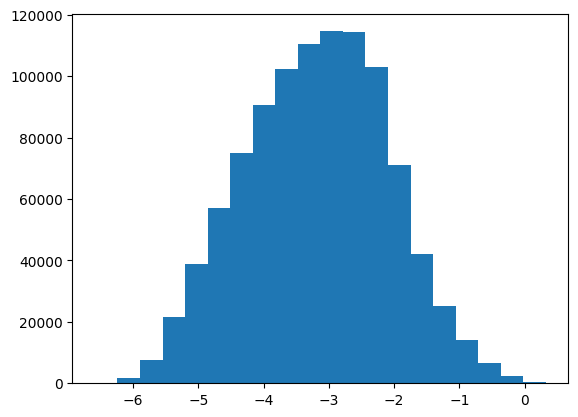

In [9]:
plt.hist(np.log10(mass_function(1, 10, sample_mass_function_parameter_priors(1000000))), bins = 20)


In [10]:
z_grid = np.linspace(0, 7, 8)
logphi1, logphi2, logMstar = select_mass_function_params(calculate_mass_function_parameters(z_grid, mass_function_redshift_parameterisation_priors(20000000)), z_grid)

ValueError: operands could not be broadcast together with shapes (20000000,8) (20000000,3) 

Text(0, 0.5, 'p(logphi1|z)')

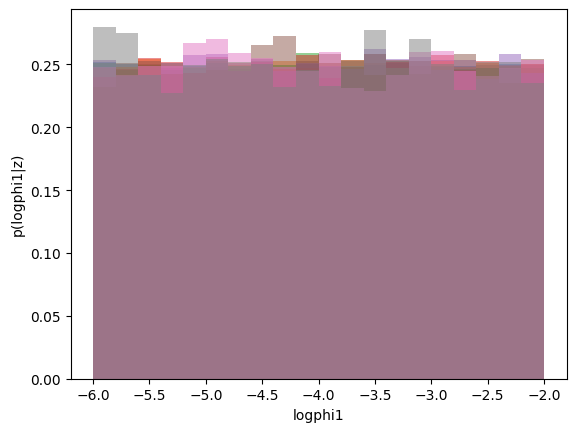

In [ ]:
for z in z_grid:
    plt.hist(logphi1[:, int(z)][logphi1[:, int(z)] != 0], bins=20, density=True, alpha=0.5)

plt.xlabel('logphi1')
plt.ylabel('p(logphi1|z)')

Text(0, 0.5, 'p(logphi2|z)')

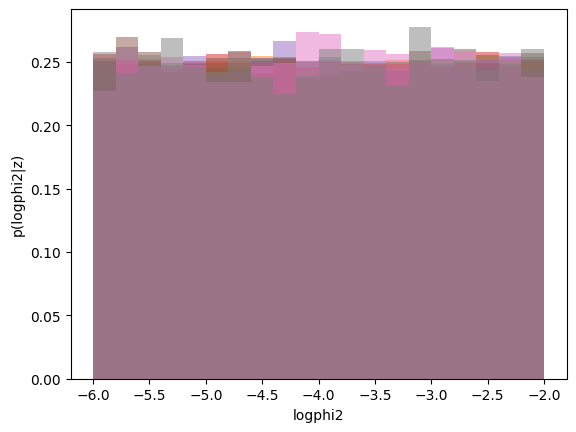

In [ ]:
for z in z_grid:
    plt.hist(logphi2[:, int(z)][logphi2[:, int(z)] != 0], bins=20, density=True, alpha=0.5)

plt.xlabel('logphi2')
plt.ylabel('p(logphi2|z)')

Text(0, 0.5, 'p(logMstar|z)')

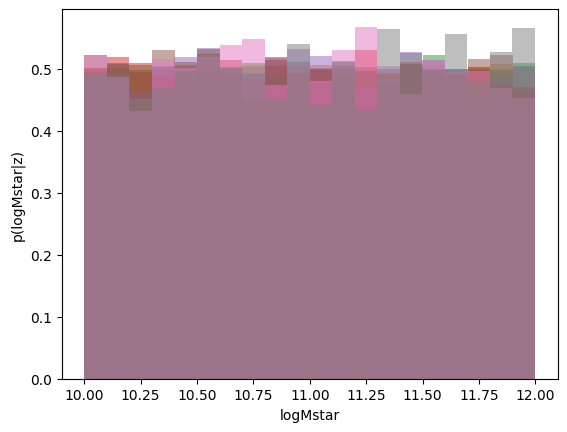

In [ ]:
for z in z_grid:
    plt.hist(logMstar[:, int(z)][logMstar[:, int(z)] != 0], bins=20, density=True, alpha=0.5)

plt.xlabel('logMstar')
plt.ylabel('p(logMstar|z)')

In [ ]:
logphi1 = np.array([-2.44, -3.08, -4.14])
logphi2 = np.array([-2.89, -3.29, -3.51])
logM_star = np.array([10.79,10.88,10.84]) 
alpha1 = np.array([-0.28]) 
alpha2 = np.array([-1.48])

params = mass_function_parameters(logphi1, logphi2, logM_star, alpha1, alpha2)

In [ ]:
def schechter(logphi, M, Mo, a):

    Mo = np.asarray([Mo]*len(M))

    return np.log(10)*(10**logphi)*10**((M-Mo)*(a+1))*np.exp(-10**(M-Mo))

def double_schechter(M, logphi1, logphi2, Mo, a1, a2):

    return schechter(logphi1, M, Mo, a1) + schechter(logphi2, M, Mo, a2)

In [ ]:
def parameter_at_z0(y,z,z1=0.2,z2=1.6,z3=3.0):

    y1,y2,y3 = y
    a = ((y3-y1) + ((y2-y1) / (z2-z1)) * (z1-z3)) / ((z3**2-z1**2 + ((z2**2-z1**2) / (z2-z1)) * (z1-z3)))
    b = ((y2-y1) - a * (z2**2-z1**2)) / (z2-z1)
    c = y1-a*z1**2-b*z1

    return a*(z**2)+b*z+c

In [ ]:
def mass_function(logm, z, 
                  y_logphi1=[-2.44, -3.08, -4.14], 
                  y_logphi2 = [-2.89, -3.29, -3.51], 
                  y_M0 = [10.79,10.88,10.84], 
                  alpha1 = [-0.28], 
                  alpha2 = [-1.48]):

    phi1 = parameter_at_z0(y_logphi1, z)
    phi2 = parameter_at_z0(y_logphi2, z)
    logM0 = parameter_at_z0(y_M0, z)

    return np.log10(double_schechter(logm, phi1, phi2, logM0, alpha1[0], alpha2[0]))



In [ ]:
def galaxy_density_fixedm(logm, z1, z2):
    
    Phi_tot = 0
    zs = np.linspace(z1, z2, 100)
    for z in zs:
        Phi_tot+=((10**mass_function(logm, z)))
    
    return Phi_tot

In [ ]:
def galaxy_density(logm1, logm2, z1, z2):
    
    Phi_tot = 0
    zs = np.linspace(z1, z2, 100)
    logms = np.linspace(logm1, logm2, 100)
    for z in zs:
        for logm in logms:
            Phi_tot+=((10**mass_function(logm, z)))
    
    return Phi_tot

In [ ]:
def background_redshift_distribution(logms, zs):

    Nz = []
    i = 1
    j = 1
    while(i < len(zs)):
        while(j < len(logms)):

            Nz.append(galaxy_density(logms[j-1], logms[j], zs[i-1], zs[i])*(WMAP9.comoving_volume(zs[i]).value-WMAP9.comoving_volume(zs[i-1]).value))

            j+=1
        i+=1

    return np.hstack(Nz)

In [ ]:
def background_redshift_distribution_fixed_m(logm, zs):

    Nz = []
    i = 1
    while(i < len(zs)):

        Nz.append(galaxy_density(logm, zs[i-1], zs[i])*(WMAP9.comoving_volume(zs[i]).value-WMAP9.comoving_volume(zs[i-1]).value))
        i+=1

    return np.hstack(Nz)

Text(0, 0.5, 'log10(phi)[Mpc-3dex-1]')

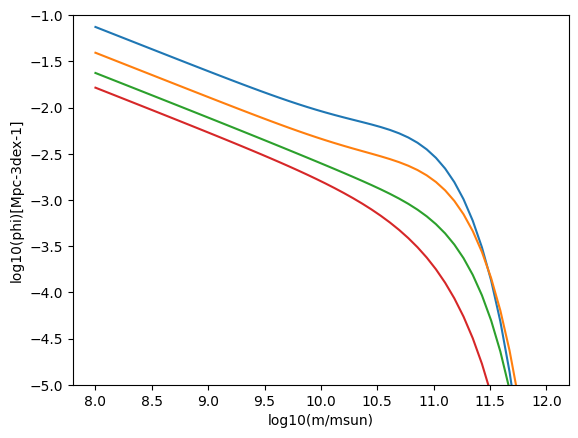

In [ ]:
mass = np.log10(np.logspace(8,12))
plt.plot(mass, mass_function(mass, 0))
plt.plot(mass, mass_function(mass, 1))
plt.plot(mass, mass_function(mass, 2))
plt.plot(mass, mass_function(mass, 3))
plt.ylim(-5, -1)
plt.xlabel('log10(m/msun)')
plt.ylabel('log10(phi)[Mpc-3dex-1]')

In [ ]:
zs = np.linspace(0, 7, 200)
logms = np.linspace(8, 12, 200)
mass = np.array([10])
Nz = background_redshift_distribution(logms, zs)
plt.plot(zs[:199], Nz)
plt.xlim(0,3)

TypeError: object of type 'numpy.float64' has no len()